In [1]:
import torch
from torch.utils.data import Dataset, Subset,DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path
import numpy as np
from typing import Tuple
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from models.resnet import resnet10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
class CustomDataset(Dataset):
    def __init__(self, txt_file, base_dir=Path("."), transform=None):
        self.paths = []
        self.transform = transform

        with open(txt_file, "r") as f:
            for line in f:
                relative_path, label = line.strip().split()
                full_path = base_dir / relative_path
                self.paths.append((full_path, int(label)))

    def __getitem__(self, idx):
        file_path, label = self.paths[idx]
        zstack = nib.load(file_path)
        data = zstack.get_fdata().astype(np.float32)

        # Normalize via log1p and min-max scaling
        data = np.log1p(data)
        data_min, data_max = data.min(), data.max()
        data = (data - data_min) / (data_max - data_min) if data_max > data_min else np.zeros_like(data)

        # Convert to tensor and add channel dimension: (1, D, H, W)
        data = torch.tensor(data).unsqueeze(0)

        # Resize to (1, 32, 256, 256) using trilinear interpolation
        data = torch.nn.functional.interpolate(
            data.unsqueeze(0),  # Add batch dimension: (1, 1, D, H, W)
            size=(32, 256, 256),
            mode='trilinear',
            align_corners=False
        ).squeeze(0)  # Remove batch dimension → (1, 32, 256, 256)

        label = torch.tensor(label, dtype=torch.float32)
        return data, label

    def __len__(self):
        return len(self.paths)

example is path: data/ZStacksWTMUT/images/MUT_0050.nii.gz and its label: 1
Class 1: 238 (50.85%)
Class 0: 230 (49.15%)


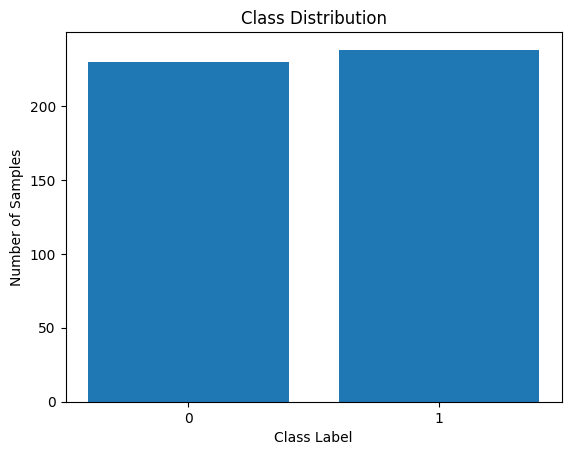

In [3]:
##APPROACH 0 - epoch 10, frozen encoder weights trained with fc layer unfrozen
# train_set = CustomDataset('data/ZStacksWTMUT/train.txt', base_dir=Path("data/ZStacksWTMUT") )
# val_set = CustomDataset('data/ZStacksWTMUT/val.txt', base_dir=Path("data/ZStacksWTMUT"))

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False)

## APPROACH 1 - epoch 10, frozen encoder weights trained with fc layer unfrozen implementing Stratified K CV
dataset = CustomDataset('data/ZStacksWTMUT/trainval.txt', base_dir=Path("data/ZStacksWTMUT") )

y = [label for _,label in dataset.paths] # path to samples
X = [path for path,label in dataset.paths] # corresponding labels
print(f'example is path: {X[0]} and its label: {y[0]}')


from collections import Counter
class_counts = Counter(y)
total = sum(class_counts.values())
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} ({count / total:.2%})")


plt.bar(class_counts.keys(), class_counts.values())
plt.xticks([0, 1])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

In [4]:
input_shape = dataset[0][0].shape
print(f'input shape is {input_shape}')

input shape is torch.Size([1, 32, 256, 256])


In [11]:
def training_loop(model, loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimiser: torch.optim.Optimizer,
                  device: torch.device) -> Tuple[float, float]:
    
    model.train()
    train_loss, total_correct, total_samples = 0.0, 0, 0

    for batch, (X, y) in tqdm(enumerate(loader), total=len(loader), desc="Training"):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        y = y.view_as(y_pred)
        loss = loss_fn(y_pred, y)

        train_loss += loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        preds = torch.sigmoid(y_pred) >= 0.5
        correct = (preds == y).sum().item()
        total_correct += correct
        total_samples += y.size(0)

    train_loss /= len(loader)
    train_acc = total_correct / total_samples

    return train_loss, train_acc

In [12]:
def validation_loop(model, loader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device: torch.device) -> Tuple[float, float]:
    
    model.eval()
    val_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad(): 
        for X, y in tqdm(loader, desc='Validation'):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y = y.view_as(y_pred)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            preds = torch.sigmoid(y_pred) >= 0.5
            correct = (preds == y).sum().item()
            total_correct += correct
            total_samples += y.size(0)

    val_loss /= len(loader)
    val_acc = total_correct / total_samples

    return val_loss, val_acc

In [14]:
all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_accuracies = []
all_fold_val_accuracies = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

num_epochs = 30

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}")

    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

    model = resnet10(sample_input_D=32, sample_input_H=256, sample_input_W=256, nclasses=1)
    pretrain_weights = "MedicalNet_pytorch_files/pretrain/resnet_10.pth"
    pretrain_model = torch.load(pretrain_weights, map_location=device)
    state_dict = pretrain_model['state_dict']
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict, strict=False)
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for e in range(num_epochs):
        train_loss, train_acc = training_loop(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = validation_loop(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {e+1}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_approach1_fold{fold+1}.pth")
        else:
            patience_counter += 1
            print(f"  ↳ No improvement in val_loss ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Save final metrics for this fold
    all_fold_train_losses.append(train_losses[-1])
    all_fold_val_losses.append(val_losses[-1])
    all_fold_train_accuracies.append(train_accuracies[-1])
    all_fold_val_accuracies.append(val_accuracies[-1])

# After all folds
print("\n===== Cross-Validation Summary =====")
print(f"Avg Train Loss: {np.mean(all_fold_train_losses):.4f}")
print(f"Avg Val Loss:   {np.mean(all_fold_val_losses):.4f}")
print(f"Avg Train Acc:  {np.mean(all_fold_train_accuracies):.4f}")
print(f"Avg Val Acc:    {np.mean(all_fold_val_accuracies):.4f}")


Fold 1


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


Epoch 1: Train Loss: 0.7167, Train Acc: 0.4920 | Val Loss: 0.6902, Val Acc: 0.4894


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]


Epoch 2: Train Loss: 0.6852, Train Acc: 0.6364 | Val Loss: 0.6764, Val Acc: 0.8830


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.84s/it]


Epoch 3: Train Loss: 0.6767, Train Acc: 0.5321 | Val Loss: 0.6637, Val Acc: 0.6170


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 4: Train Loss: 0.6703, Train Acc: 0.6203 | Val Loss: 0.6571, Val Acc: 0.6064


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 5: Train Loss: 0.6650, Train Acc: 0.5374 | Val Loss: 0.6453, Val Acc: 0.5106


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 6: Train Loss: 0.6576, Train Acc: 0.5107 | Val Loss: 0.6419, Val Acc: 0.4894


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 7: Train Loss: 0.6542, Train Acc: 0.5160 | Val Loss: 0.6343, Val Acc: 0.5000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.84s/it]


Epoch 8: Train Loss: 0.6470, Train Acc: 0.5749 | Val Loss: 0.6290, Val Acc: 0.4787


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 9: Train Loss: 0.6432, Train Acc: 0.5535 | Val Loss: 0.6237, Val Acc: 0.6064


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 10: Train Loss: 0.6409, Train Acc: 0.5775 | Val Loss: 0.6169, Val Acc: 0.5106


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


Epoch 11: Train Loss: 0.6352, Train Acc: 0.6096 | Val Loss: 0.6080, Val Acc: 0.6277


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.96s/it]


Epoch 12: Train Loss: 0.6324, Train Acc: 0.5775 | Val Loss: 0.6074, Val Acc: 0.7128


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.98s/it]


Epoch 13: Train Loss: 0.6243, Train Acc: 0.6738 | Val Loss: 0.6022, Val Acc: 0.7766


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.92s/it]


Epoch 14: Train Loss: 0.6213, Train Acc: 0.6631 | Val Loss: 0.5954, Val Acc: 0.8936


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


Epoch 15: Train Loss: 0.6163, Train Acc: 0.6872 | Val Loss: 0.5857, Val Acc: 0.8723


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]


Epoch 16: Train Loss: 0.6142, Train Acc: 0.6898 | Val Loss: 0.5879, Val Acc: 0.7872
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.20s/it]


Epoch 17: Train Loss: 0.6053, Train Acc: 0.7326 | Val Loss: 0.5820, Val Acc: 0.8085


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.08s/it]


Epoch 18: Train Loss: 0.6098, Train Acc: 0.7299 | Val Loss: 0.5779, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.99s/it]


Epoch 19: Train Loss: 0.6078, Train Acc: 0.7701 | Val Loss: 0.5791, Val Acc: 0.7872
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.05s/it]


Epoch 20: Train Loss: 0.5921, Train Acc: 0.7594 | Val Loss: 0.5647, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.03s/it]


Epoch 21: Train Loss: 0.5995, Train Acc: 0.7326 | Val Loss: 0.5656, Val Acc: 0.7872
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]


Epoch 22: Train Loss: 0.5871, Train Acc: 0.7834 | Val Loss: 0.5612, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 23: Train Loss: 0.5875, Train Acc: 0.7513 | Val Loss: 0.5630, Val Acc: 0.7766
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 24: Train Loss: 0.5892, Train Acc: 0.7326 | Val Loss: 0.5439, Val Acc: 0.8085


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.81s/it]


Epoch 25: Train Loss: 0.5775, Train Acc: 0.7888 | Val Loss: 0.5516, Val Acc: 0.7766
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


Epoch 26: Train Loss: 0.5741, Train Acc: 0.7727 | Val Loss: 0.5479, Val Acc: 0.7766
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 27: Train Loss: 0.5746, Train Acc: 0.7513 | Val Loss: 0.5402, Val Acc: 0.7766


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.88s/it]


Epoch 28: Train Loss: 0.5764, Train Acc: 0.7701 | Val Loss: 0.5232, Val Acc: 0.7979


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.10s/it]


Epoch 29: Train Loss: 0.5793, Train Acc: 0.7246 | Val Loss: 0.5283, Val Acc: 0.7872
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 30: Train Loss: 0.5724, Train Acc: 0.7968 | Val Loss: 0.5289, Val Acc: 0.7766
  ↳ No improvement in val_loss (2/3)

Fold 2


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.64s/it]


Epoch 1: Train Loss: 0.6908, Train Acc: 0.5080 | Val Loss: 0.6921, Val Acc: 0.5106


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.09s/it]


Epoch 2: Train Loss: 0.6821, Train Acc: 0.4786 | Val Loss: 0.6848, Val Acc: 0.4894


Validation: 100%|███████████████████████████████| 12/12 [01:53<00:00,  9.46s/it]


Epoch 3: Train Loss: 0.6760, Train Acc: 0.4786 | Val Loss: 0.6785, Val Acc: 0.4468


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.06s/it]


Epoch 4: Train Loss: 0.6677, Train Acc: 0.5027 | Val Loss: 0.6730, Val Acc: 0.3723


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.98s/it]


Epoch 5: Train Loss: 0.6689, Train Acc: 0.4866 | Val Loss: 0.6696, Val Acc: 0.3617


Validation: 100%|███████████████████████████████| 12/12 [01:52<00:00,  9.37s/it]


Epoch 6: Train Loss: 0.6555, Train Acc: 0.5294 | Val Loss: 0.6625, Val Acc: 0.3830


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.04s/it]


Epoch 7: Train Loss: 0.6547, Train Acc: 0.4652 | Val Loss: 0.6516, Val Acc: 0.3617


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.06s/it]


Epoch 8: Train Loss: 0.6510, Train Acc: 0.5187 | Val Loss: 0.6528, Val Acc: 0.4255
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]


Epoch 9: Train Loss: 0.6431, Train Acc: 0.5321 | Val Loss: 0.6416, Val Acc: 0.3830


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 10: Train Loss: 0.6439, Train Acc: 0.4759 | Val Loss: 0.6340, Val Acc: 0.3617


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.01s/it]


Epoch 11: Train Loss: 0.6401, Train Acc: 0.4947 | Val Loss: 0.6275, Val Acc: 0.3936


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.24s/it]


Epoch 12: Train Loss: 0.6345, Train Acc: 0.5749 | Val Loss: 0.6257, Val Acc: 0.5532


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.93s/it]


Epoch 13: Train Loss: 0.6314, Train Acc: 0.5294 | Val Loss: 0.6137, Val Acc: 0.3830


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


Epoch 14: Train Loss: 0.6235, Train Acc: 0.5187 | Val Loss: 0.6093, Val Acc: 0.5745


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.92s/it]


Epoch 15: Train Loss: 0.6217, Train Acc: 0.6283 | Val Loss: 0.6084, Val Acc: 0.5851


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.93s/it]


Epoch 16: Train Loss: 0.6144, Train Acc: 0.6337 | Val Loss: 0.5994, Val Acc: 0.5957


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]


Epoch 17: Train Loss: 0.6138, Train Acc: 0.6283 | Val Loss: 0.5931, Val Acc: 0.7447


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.10s/it]


Epoch 18: Train Loss: 0.6108, Train Acc: 0.6283 | Val Loss: 0.5890, Val Acc: 0.7553


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.13s/it]


Epoch 19: Train Loss: 0.6109, Train Acc: 0.6925 | Val Loss: 0.5913, Val Acc: 0.7447
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.98s/it]


Epoch 20: Train Loss: 0.5986, Train Acc: 0.7219 | Val Loss: 0.5862, Val Acc: 0.7553


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 21: Train Loss: 0.6016, Train Acc: 0.7005 | Val Loss: 0.5848, Val Acc: 0.7447


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.10s/it]


Epoch 22: Train Loss: 0.6040, Train Acc: 0.7166 | Val Loss: 0.5633, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.10s/it]


Epoch 23: Train Loss: 0.5965, Train Acc: 0.7353 | Val Loss: 0.5688, Val Acc: 0.7553
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]


Epoch 24: Train Loss: 0.5995, Train Acc: 0.6925 | Val Loss: 0.5675, Val Acc: 0.7660
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]


Epoch 25: Train Loss: 0.5920, Train Acc: 0.7166 | Val Loss: 0.5631, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


Epoch 26: Train Loss: 0.5755, Train Acc: 0.7914 | Val Loss: 0.5553, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.16s/it]


Epoch 27: Train Loss: 0.5802, Train Acc: 0.7647 | Val Loss: 0.5547, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.12s/it]


Epoch 28: Train Loss: 0.5792, Train Acc: 0.7594 | Val Loss: 0.5549, Val Acc: 0.7872
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.95s/it]


Epoch 29: Train Loss: 0.5759, Train Acc: 0.7273 | Val Loss: 0.5458, Val Acc: 0.7660


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]


Epoch 30: Train Loss: 0.5663, Train Acc: 0.7487 | Val Loss: 0.5456, Val Acc: 0.7872

Fold 3


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  9.00s/it]


Epoch 1: Train Loss: 0.6661, Train Acc: 0.7914 | Val Loss: 0.6702, Val Acc: 0.5106


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.20s/it]


Epoch 2: Train Loss: 0.6581, Train Acc: 0.5802 | Val Loss: 0.6419, Val Acc: 0.6596


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.25s/it]


Epoch 3: Train Loss: 0.6564, Train Acc: 0.5749 | Val Loss: 0.6363, Val Acc: 0.6915


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.91s/it]


Epoch 4: Train Loss: 0.6485, Train Acc: 0.5963 | Val Loss: 0.6211, Val Acc: 0.5851


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.01s/it]


Epoch 5: Train Loss: 0.6404, Train Acc: 0.5909 | Val Loss: 0.6235, Val Acc: 0.6277
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.99s/it]


Epoch 6: Train Loss: 0.6357, Train Acc: 0.5668 | Val Loss: 0.6149, Val Acc: 0.7128


Validation: 100%|███████████████████████████████| 12/12 [01:52<00:00,  9.36s/it]


Epoch 7: Train Loss: 0.6331, Train Acc: 0.6283 | Val Loss: 0.6110, Val Acc: 0.6170


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.24s/it]


Epoch 8: Train Loss: 0.6294, Train Acc: 0.5802 | Val Loss: 0.6027, Val Acc: 0.7553


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.04s/it]


Epoch 9: Train Loss: 0.6274, Train Acc: 0.6390 | Val Loss: 0.5886, Val Acc: 0.7447


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.87s/it]


Epoch 10: Train Loss: 0.6212, Train Acc: 0.6979 | Val Loss: 0.5912, Val Acc: 0.7660
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]


Epoch 11: Train Loss: 0.6219, Train Acc: 0.6818 | Val Loss: 0.5929, Val Acc: 0.7766
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]


Epoch 12: Train Loss: 0.6162, Train Acc: 0.7139 | Val Loss: 0.5764, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.16s/it]


Epoch 13: Train Loss: 0.6082, Train Acc: 0.6979 | Val Loss: 0.5745, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.29s/it]


Epoch 14: Train Loss: 0.6166, Train Acc: 0.6979 | Val Loss: 0.5783, Val Acc: 0.7766
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.03s/it]


Epoch 15: Train Loss: 0.6076, Train Acc: 0.7380 | Val Loss: 0.5676, Val Acc: 0.7766


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]


Epoch 16: Train Loss: 0.6020, Train Acc: 0.7701 | Val Loss: 0.5634, Val Acc: 0.7766


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.29s/it]


Epoch 17: Train Loss: 0.5990, Train Acc: 0.7487 | Val Loss: 0.5516, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.91s/it]


Epoch 18: Train Loss: 0.5942, Train Acc: 0.7888 | Val Loss: 0.5462, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.33s/it]


Epoch 19: Train Loss: 0.6015, Train Acc: 0.7193 | Val Loss: 0.5561, Val Acc: 0.7872
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.28s/it]


Epoch 20: Train Loss: 0.5936, Train Acc: 0.7353 | Val Loss: 0.5503, Val Acc: 0.7872
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:53<00:00,  9.44s/it]


Epoch 21: Train Loss: 0.5841, Train Acc: 0.7995 | Val Loss: 0.5432, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.23s/it]


Epoch 22: Train Loss: 0.5830, Train Acc: 0.7513 | Val Loss: 0.5409, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.08s/it]


Epoch 23: Train Loss: 0.5892, Train Acc: 0.7326 | Val Loss: 0.5235, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 12/12 [01:54<00:00,  9.52s/it]


Epoch 24: Train Loss: 0.5714, Train Acc: 0.7701 | Val Loss: 0.5290, Val Acc: 0.7872
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.12s/it]


Epoch 25: Train Loss: 0.5736, Train Acc: 0.7487 | Val Loss: 0.5340, Val Acc: 0.7872
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.08s/it]


Epoch 26: Train Loss: 0.5772, Train Acc: 0.7460 | Val Loss: 0.5419, Val Acc: 0.7872
  ↳ No improvement in val_loss (3/3)
Early stopping triggered.

Fold 4


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.14s/it]


Epoch 1: Train Loss: 0.7083, Train Acc: 0.2827 | Val Loss: 0.6980, Val Acc: 0.4301


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.28s/it]


Epoch 2: Train Loss: 0.6959, Train Acc: 0.4507 | Val Loss: 0.6913, Val Acc: 0.5054


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.95s/it]


Epoch 3: Train Loss: 0.6895, Train Acc: 0.4693 | Val Loss: 0.6845, Val Acc: 0.5054


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.73s/it]


Epoch 4: Train Loss: 0.6802, Train Acc: 0.4853 | Val Loss: 0.6783, Val Acc: 0.4086


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 5: Train Loss: 0.6738, Train Acc: 0.4427 | Val Loss: 0.6728, Val Acc: 0.5376


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 6: Train Loss: 0.6684, Train Acc: 0.4720 | Val Loss: 0.6660, Val Acc: 0.5376


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.26s/it]


Epoch 7: Train Loss: 0.6597, Train Acc: 0.4880 | Val Loss: 0.6595, Val Acc: 0.3871


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.04s/it]


Epoch 8: Train Loss: 0.6553, Train Acc: 0.4587 | Val Loss: 0.6562, Val Acc: 0.3763


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.87s/it]


Epoch 9: Train Loss: 0.6498, Train Acc: 0.5040 | Val Loss: 0.6480, Val Acc: 0.3763


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 10: Train Loss: 0.6524, Train Acc: 0.4960 | Val Loss: 0.6462, Val Acc: 0.5161


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.05s/it]


Epoch 11: Train Loss: 0.6458, Train Acc: 0.5067 | Val Loss: 0.6434, Val Acc: 0.5161


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.08s/it]


Epoch 12: Train Loss: 0.6355, Train Acc: 0.5200 | Val Loss: 0.6384, Val Acc: 0.4301


Validation: 100%|██████████████████████████████| 12/12 [38:44<00:00, 193.70s/it]


Epoch 13: Train Loss: 0.6336, Train Acc: 0.5227 | Val Loss: 0.6306, Val Acc: 0.5699


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.95s/it]


Epoch 14: Train Loss: 0.6321, Train Acc: 0.5467 | Val Loss: 0.6265, Val Acc: 0.5161


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.83s/it]


Epoch 15: Train Loss: 0.6218, Train Acc: 0.6267 | Val Loss: 0.6249, Val Acc: 0.5484


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.77s/it]


Epoch 16: Train Loss: 0.6242, Train Acc: 0.5733 | Val Loss: 0.6155, Val Acc: 0.6129


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.75s/it]


Epoch 17: Train Loss: 0.6218, Train Acc: 0.6027 | Val Loss: 0.6131, Val Acc: 0.7204


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.75s/it]


Epoch 18: Train Loss: 0.6174, Train Acc: 0.6693 | Val Loss: 0.6141, Val Acc: 0.7204
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.77s/it]


Epoch 19: Train Loss: 0.6101, Train Acc: 0.6827 | Val Loss: 0.6101, Val Acc: 0.7097


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.74s/it]


Epoch 20: Train Loss: 0.6047, Train Acc: 0.6933 | Val Loss: 0.6033, Val Acc: 0.7312


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.75s/it]


Epoch 21: Train Loss: 0.6025, Train Acc: 0.7013 | Val Loss: 0.6011, Val Acc: 0.7312


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.78s/it]


Epoch 22: Train Loss: 0.5954, Train Acc: 0.7413 | Val Loss: 0.5935, Val Acc: 0.8172


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.74s/it]


Epoch 23: Train Loss: 0.5955, Train Acc: 0.7093 | Val Loss: 0.5961, Val Acc: 0.7204
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.75s/it]


Epoch 24: Train Loss: 0.5843, Train Acc: 0.7840 | Val Loss: 0.5929, Val Acc: 0.7849


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.75s/it]


Epoch 25: Train Loss: 0.5858, Train Acc: 0.7547 | Val Loss: 0.5913, Val Acc: 0.7634


Validation: 100%|███████████████████████████████| 12/12 [01:58<00:00,  9.91s/it]


Epoch 26: Train Loss: 0.5784, Train Acc: 0.7920 | Val Loss: 0.5812, Val Acc: 0.7634


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 27: Train Loss: 0.5842, Train Acc: 0.7600 | Val Loss: 0.5776, Val Acc: 0.7204


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.75s/it]


Epoch 28: Train Loss: 0.5754, Train Acc: 0.7707 | Val Loss: 0.5730, Val Acc: 0.7312


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 29: Train Loss: 0.5689, Train Acc: 0.7440 | Val Loss: 0.5730, Val Acc: 0.7312
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


Epoch 30: Train Loss: 0.5784, Train Acc: 0.7440 | Val Loss: 0.5701, Val Acc: 0.7204

Fold 5


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.67s/it]


Epoch 1: Train Loss: 0.7090, Train Acc: 0.3733 | Val Loss: 0.6877, Val Acc: 0.4946


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


Epoch 2: Train Loss: 0.6867, Train Acc: 0.5947 | Val Loss: 0.6726, Val Acc: 0.7312


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.97s/it]


Epoch 3: Train Loss: 0.6780, Train Acc: 0.5920 | Val Loss: 0.6611, Val Acc: 0.7097


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


Epoch 4: Train Loss: 0.6692, Train Acc: 0.5387 | Val Loss: 0.6531, Val Acc: 0.5054


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


Epoch 5: Train Loss: 0.6608, Train Acc: 0.5013 | Val Loss: 0.6489, Val Acc: 0.4946


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]


Epoch 6: Train Loss: 0.6586, Train Acc: 0.5253 | Val Loss: 0.6322, Val Acc: 0.4946


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 7: Train Loss: 0.6525, Train Acc: 0.5573 | Val Loss: 0.6370, Val Acc: 0.4516
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.70s/it]


Epoch 8: Train Loss: 0.6456, Train Acc: 0.5280 | Val Loss: 0.6216, Val Acc: 0.4839


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.59s/it]


Epoch 9: Train Loss: 0.6451, Train Acc: 0.4880 | Val Loss: 0.6214, Val Acc: 0.4946


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.66s/it]


Epoch 10: Train Loss: 0.6431, Train Acc: 0.5573 | Val Loss: 0.6070, Val Acc: 0.5054


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.67s/it]


Epoch 11: Train Loss: 0.6377, Train Acc: 0.6000 | Val Loss: 0.6152, Val Acc: 0.7527
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.63s/it]


Epoch 12: Train Loss: 0.6296, Train Acc: 0.5707 | Val Loss: 0.6009, Val Acc: 0.5054


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 13: Train Loss: 0.6276, Train Acc: 0.6453 | Val Loss: 0.6040, Val Acc: 0.8602
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.75s/it]


Epoch 14: Train Loss: 0.6252, Train Acc: 0.6373 | Val Loss: 0.5934, Val Acc: 0.8602


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.74s/it]


Epoch 15: Train Loss: 0.6220, Train Acc: 0.6613 | Val Loss: 0.5843, Val Acc: 0.7742


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.73s/it]


Epoch 16: Train Loss: 0.6105, Train Acc: 0.7093 | Val Loss: 0.5822, Val Acc: 0.8495


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.73s/it]


Epoch 17: Train Loss: 0.6093, Train Acc: 0.7360 | Val Loss: 0.5809, Val Acc: 0.7634


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.75s/it]


Epoch 18: Train Loss: 0.6107, Train Acc: 0.7147 | Val Loss: 0.5775, Val Acc: 0.7634


Validation: 100%|███████████████████████████████| 12/12 [03:38<00:00, 18.18s/it]


Epoch 19: Train Loss: 0.5969, Train Acc: 0.7973 | Val Loss: 0.5713, Val Acc: 0.9032


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.77s/it]


Epoch 20: Train Loss: 0.5993, Train Acc: 0.7493 | Val Loss: 0.5679, Val Acc: 0.7634


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 21: Train Loss: 0.6023, Train Acc: 0.7013 | Val Loss: 0.5575, Val Acc: 0.7742


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 22: Train Loss: 0.5902, Train Acc: 0.7333 | Val Loss: 0.5606, Val Acc: 0.7634
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.75s/it]


Epoch 23: Train Loss: 0.5874, Train Acc: 0.7627 | Val Loss: 0.5591, Val Acc: 0.7849
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 24: Train Loss: 0.5865, Train Acc: 0.7600 | Val Loss: 0.5399, Val Acc: 0.7957


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 25: Train Loss: 0.5833, Train Acc: 0.7280 | Val Loss: 0.5480, Val Acc: 0.7849
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.78s/it]


Epoch 26: Train Loss: 0.5786, Train Acc: 0.7813 | Val Loss: 0.5394, Val Acc: 0.8280


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 27: Train Loss: 0.5769, Train Acc: 0.8000 | Val Loss: 0.5446, Val Acc: 0.7849
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.81s/it]


Epoch 28: Train Loss: 0.5802, Train Acc: 0.7280 | Val Loss: 0.5456, Val Acc: 0.7957
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.75s/it]


Epoch 29: Train Loss: 0.5748, Train Acc: 0.7573 | Val Loss: 0.5319, Val Acc: 0.7957


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]

Epoch 30: Train Loss: 0.5721, Train Acc: 0.7227 | Val Loss: 0.5299, Val Acc: 0.7634

===== Cross-Validation Summary =====
Avg Train Loss: 0.5733
Avg Val Loss:   0.5433
Avg Train Acc:  0.7516
Avg Val Acc:    0.7670


In [24]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from pathlib import Path
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of best model files for each fold
model_paths = [
    "best_model_approach1_fold1.pth",
    "best_model_approach1_fold2.pth",
    "best_model_approach1_fold3.pth",
    "best_model_approach1_fold4.pth",
    "best_model_approach1_fold5.pth"
]

# Set up test dataset
test_set = CustomDataset('data/ZStacksWTMUT/test.txt', base_dir=Path("data/ZStacksWTMUT"))
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Store metrics for all folds
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

for fold, model_path in enumerate(model_paths, 1):
    model = resnet10(sample_input_D=32, sample_input_H=256, sample_input_W=256, nclasses=1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Fold {fold}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs).view(-1)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"\nFold {fold} Results:")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1 Score  : {f1:.4f}")
    print(f"  ROC AUC   : {roc_auc:.4f}")

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    metrics['roc_auc'].append(roc_auc)

# Final average + std
print("\n===== Cross-Fold Test Summary =====")
for key in metrics:
    mean = np.mean(metrics[key])
    std = np.std(metrics[key])
    print(f"{key.capitalize():<10}: {mean:.4f} ± {std:.4f}")

Fold 1: 100%|███████████████████████████████████| 25/25 [00:28<00:00,  1.14s/it]



Fold 1 Results:
  Accuracy  : 0.7600
  Precision : 0.8889
  Recall    : 0.6154
  F1 Score  : 0.7273
  ROC AUC   : 0.9295


Fold 2: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.19s/it]



Fold 2 Results:
  Accuracy  : 0.8000
  Precision : 1.0000
  Recall    : 0.6154
  F1 Score  : 0.7619
  ROC AUC   : 0.9744


Fold 3: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.17s/it]



Fold 3 Results:
  Accuracy  : 0.7600
  Precision : 0.8889
  Recall    : 0.6154
  F1 Score  : 0.7273
  ROC AUC   : 0.9551


Fold 4: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.20s/it]



Fold 4 Results:
  Accuracy  : 0.8000
  Precision : 1.0000
  Recall    : 0.6154
  F1 Score  : 0.7619
  ROC AUC   : 0.9551


Fold 5: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.20s/it]


Fold 5 Results:
  Accuracy  : 0.8000
  Precision : 1.0000
  Recall    : 0.6154
  F1 Score  : 0.7619
  ROC AUC   : 0.9551

===== Cross-Fold Test Summary =====
Accuracy  : 0.7840 ± 0.0196
Precision : 0.9556 ± 0.0544
Recall    : 0.6154 ± 0.0000
F1        : 0.7481 ± 0.0170
Roc_auc   : 0.9538 ± 0.0143
